# Investigation

The API homepage lets you download CSVs of historical forecast and actual CI. These are (presumably) the final forecast values for the given time window. Here I check the forecast error.

In [20]:
%matplotlib inline

import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scrape.files import get_data_files
from scrape.graph import _ftime

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

# Get data files 2022-23
files = get_data_files("data/samples", extension=".csv")

df = pd.concat([pd.read_csv(fp, index_col=0) for fp in sorted(files)])

# Drop duplicates from overlapping dates
df = df[~df.index.duplicated(keep="last")]

df.index = pd.to_datetime(df.index)

In [21]:
df["error"] = df["Forecast Carbon Intensity (gCO2/kWh)"].sub(df["Actual Carbon Intensity (gCO2/kWh)"])
df["percentage error"] = 100. * df["error"].div(df["Actual Carbon Intensity (gCO2/kWh)"])
df.tail()

,Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,error,percentage error
Datetime (UTC),,,,,
2023-03-30 22:00:00+00:00,81.0,139,low,58.0,71.604938
2023-03-30 22:30:00+00:00,77.0,129,low,52.0,67.532468
2023-03-30 23:00:00+00:00,78.0,105,low,27.0,34.615385
2023-03-30 23:30:00+00:00,77.0,85,low,8.0,10.389610
2023-03-31 00:00:00+00:00,82.0,81,low,-1.0,-1.219512


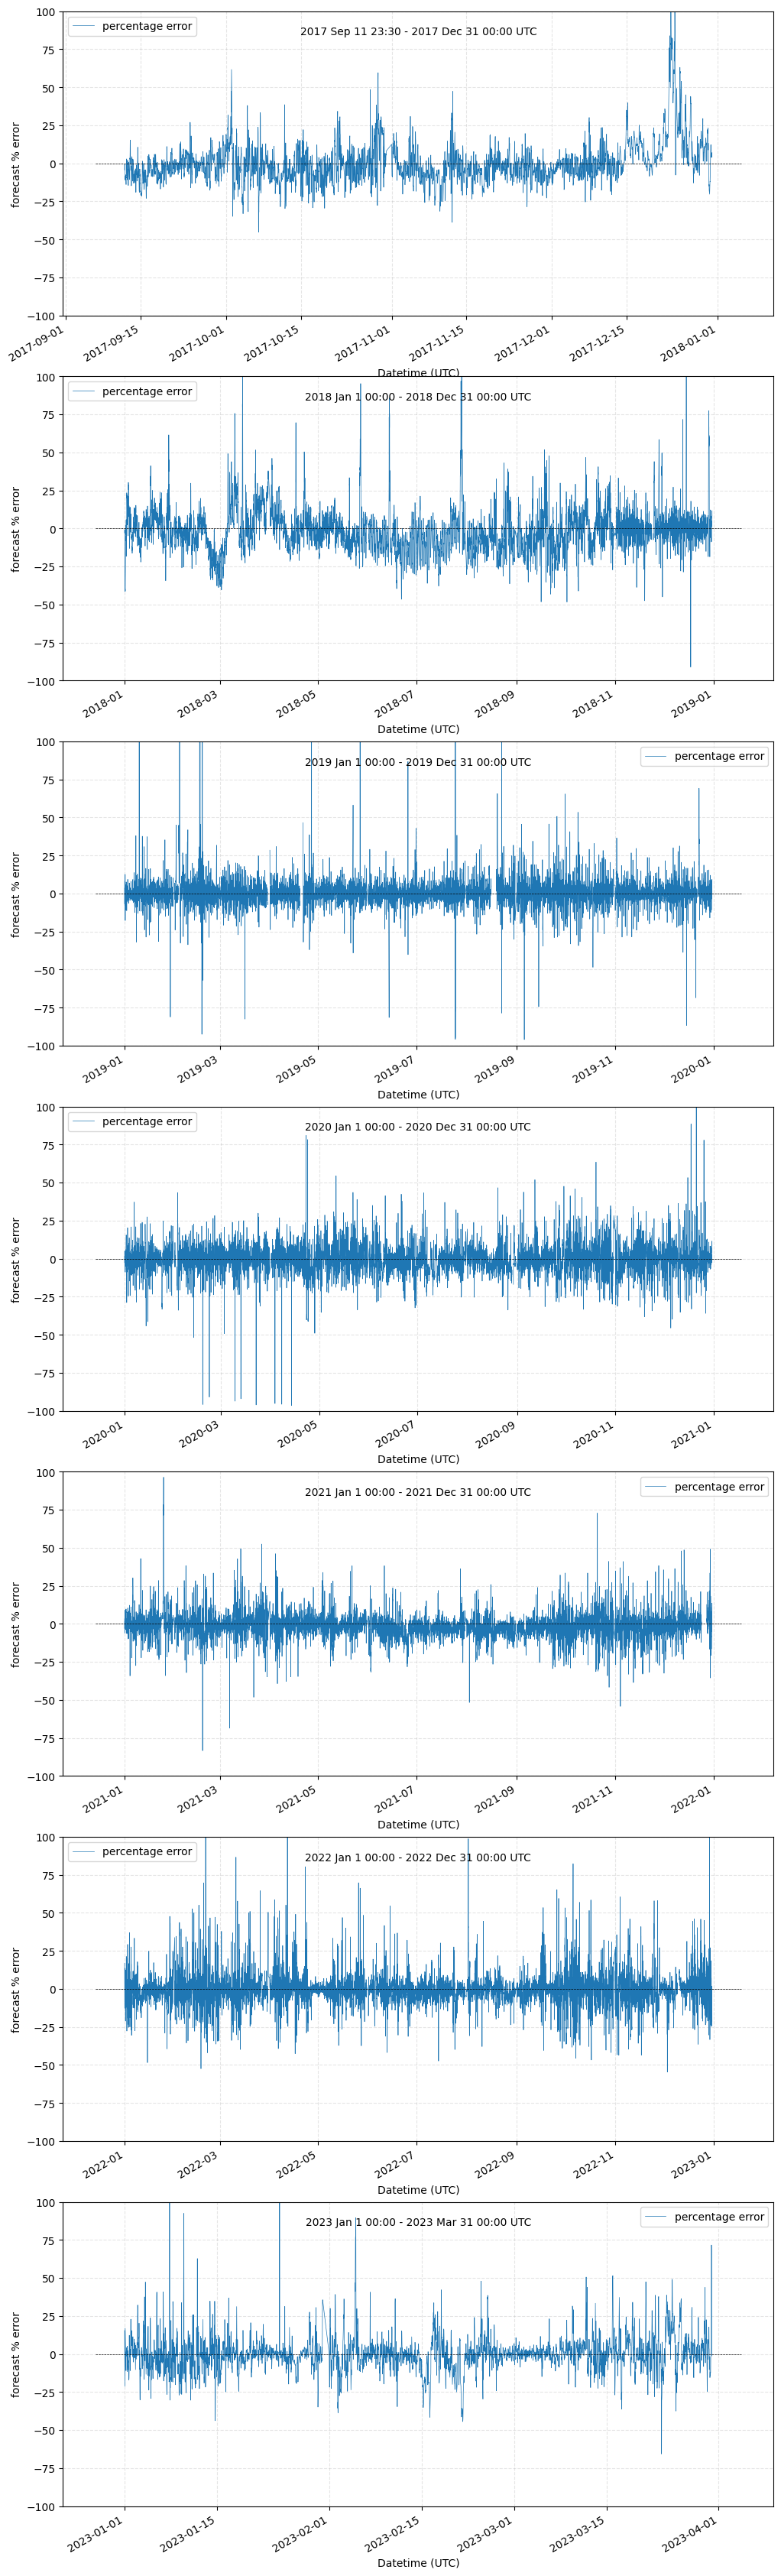

In [23]:
# Get unique years from the index and plot by year
years = list({dt.year: "" for dt in df.index}.keys())

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(len(years), 1, sharex=False, sharey="col")
for ix, ax in enumerate(axes):
    dates = [d for d in df.index if d.year == years[ix]]
    df.loc[dates, ["percentage error"]].plot(ax=ax, linewidth=0.5)
    
    title = f"{_ftime(dates[0])} - {_ftime(dates[-1])} UTC"
    ax.text(0.5, 0.95, title, horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
    
#     ax.set_title()
    ax.set_ylabel("forecast % error")
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.hlines(
        0.0,
        ax.get_xlim()[0],
        ax.get_xlim()[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )

ax.set_ylim(-100,100)
    
plt.show()

In [ ]:
ax = df.plot(use_index=True, y="percentage error", linewidth=0.5, label=r"percentage error")

ax.set_ylim(-80,125)
ax.set_title(f"{_ftime(df.index[0])} - {_ftime(df.index[-1])} UTC")
ax.set_ylabel("forecast % error")
ax.grid("on", linestyle="--", alpha=0.33)
ax.hlines(
    0.0,
    ax.get_xlim()[0],
    ax.get_xlim()[-1],
    color="k",
    linestyle="--",
    linewidth=0.5,
)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()

ax.set_xticks(xticks, xlabels, rotation=90, ha="center")

locator = mdates.MonthLocator(interval=1)  # every month
fmt = mdates.DateFormatter("%Y-%b")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

fig = plt.gcf()
fig.suptitle(f"Percentage national forecast error, {len(df.index)} half-hour windows")

Text(0.5, 0.98, 'Percentage national forecast error, 95407 half-hour windows')

In [6]:
# The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
print(df["percentage error"].abs().mean(), df["percentage error"].std())

7.147381369675848 29.26346713524063


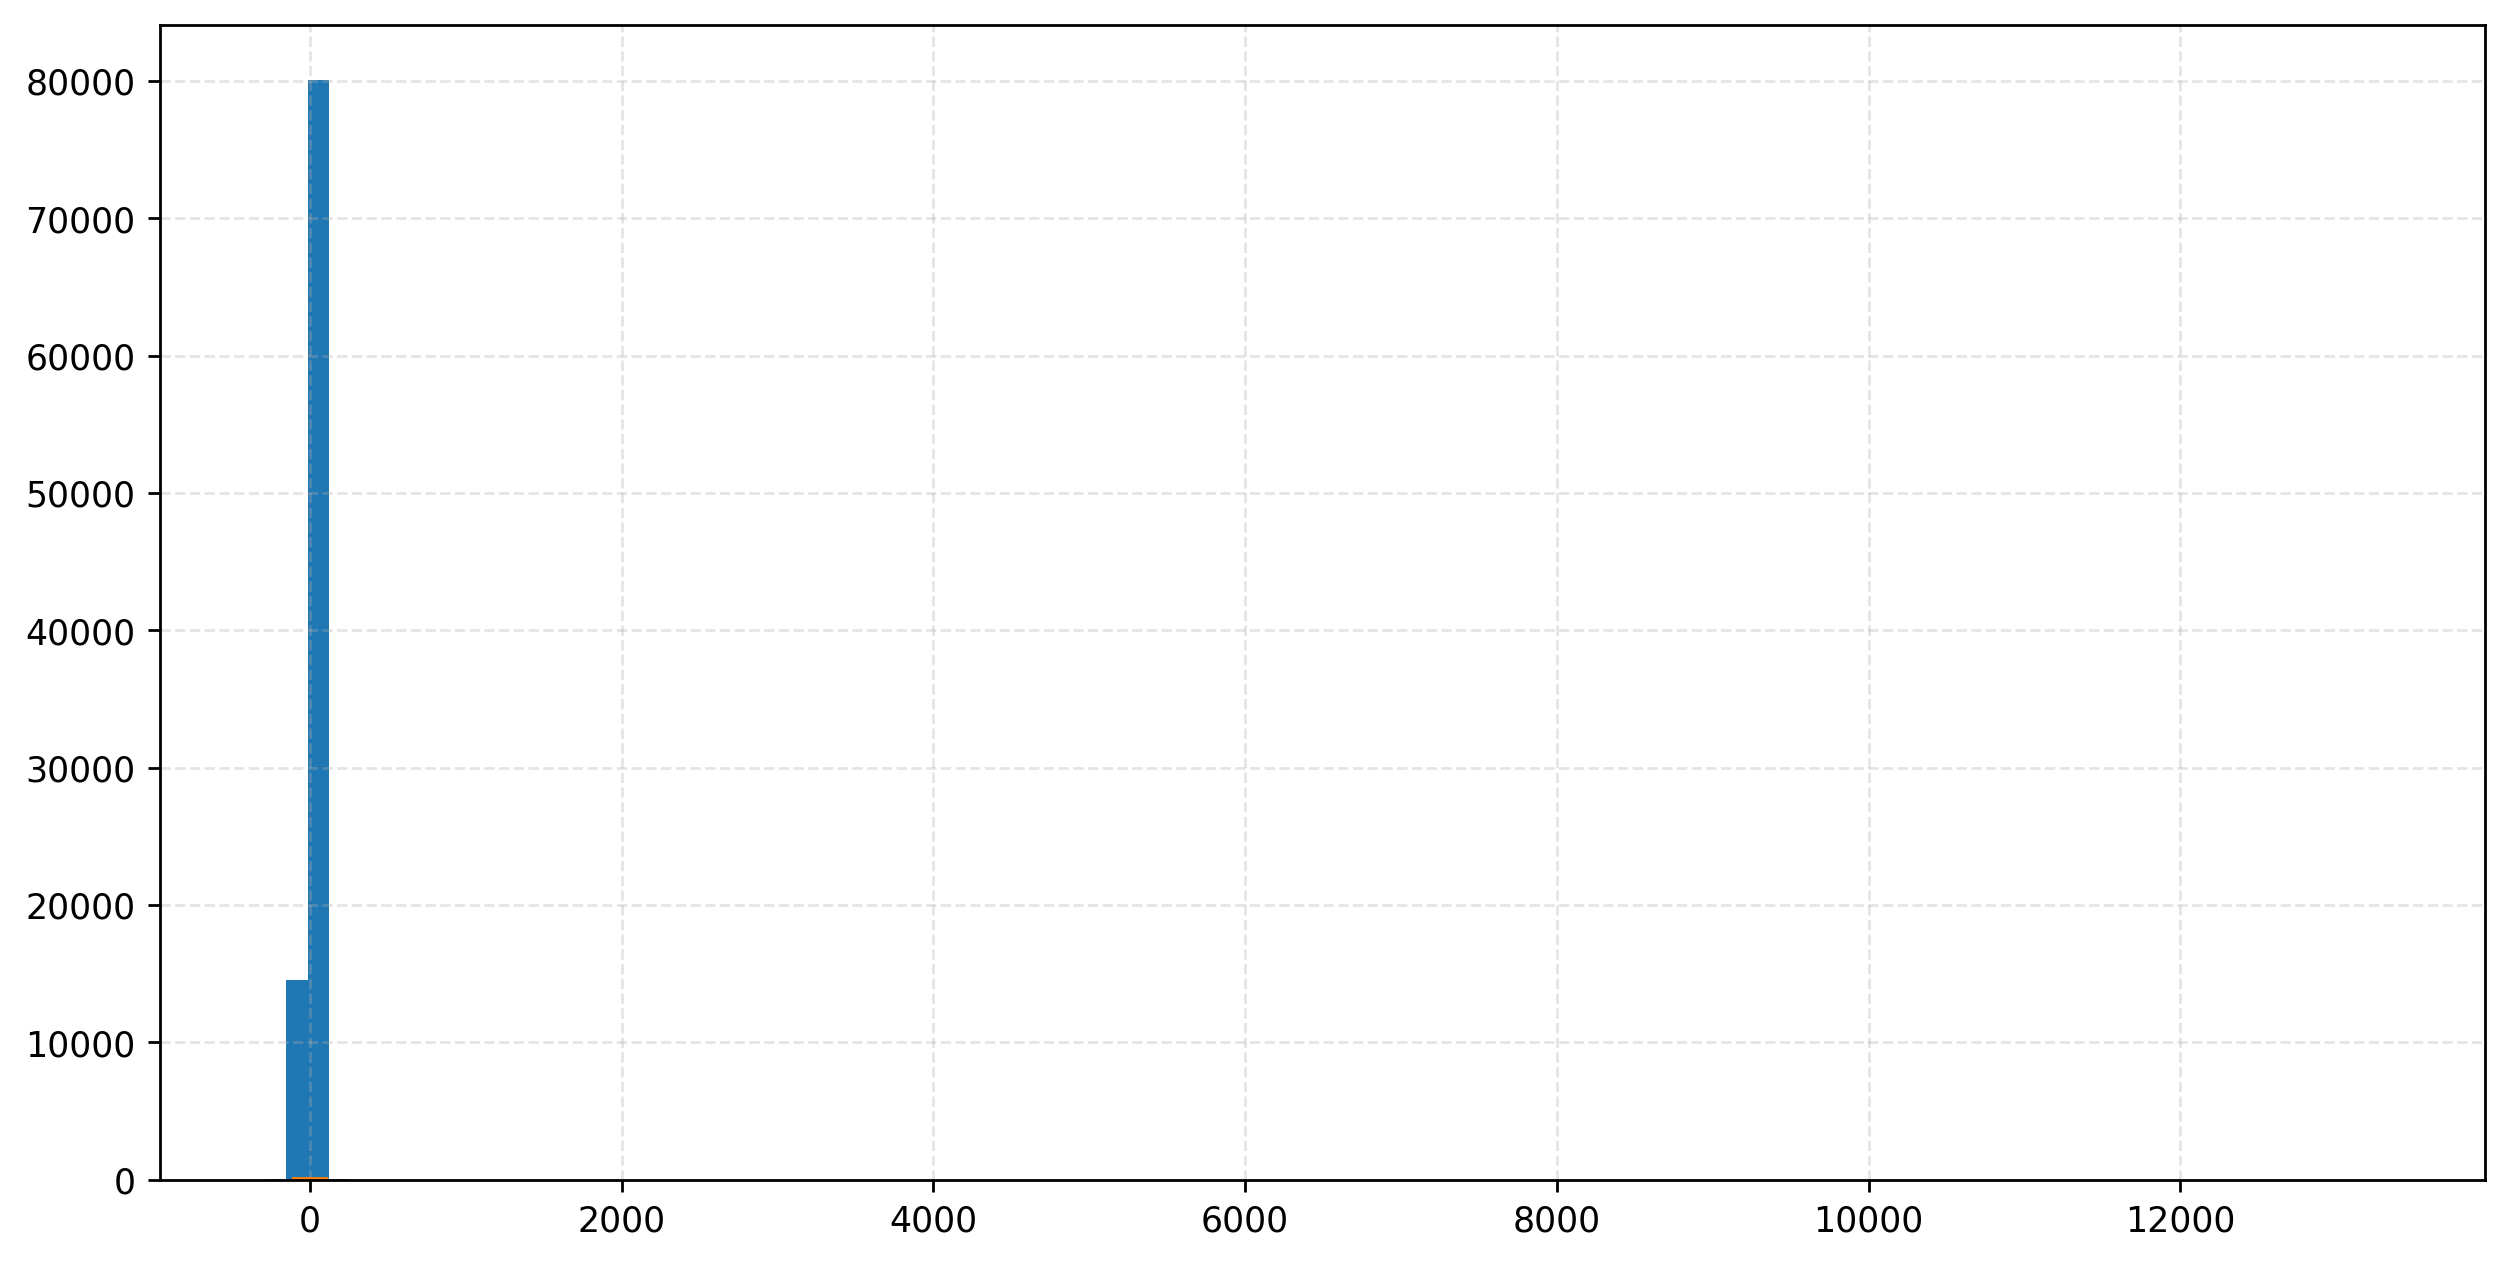

In [9]:
ax = df["error"].hist(bins=100)
ax.grid("on", linestyle="--", alpha=0.33)

from scipy.stats import t

m = df["error"].mean()
scale = df["error"].std()
dof = len(df["error"]) - 1

# random sample
samp = t.rvs(df=dof, loc=m, scale=scale, size=100000)
param = t.fit(samp)

# x = np.linspace(-100,100,10000)

x = np.arange(-100, 100, 0.1)
pdf_fitted = t.pdf(x, df=param[0], loc=param[1], scale=param[2])

ax.plot(x, pdf_fitted)

# y = stats.norm.pdf(x, df["error"].mean(), df["error"].std()) * 90000
# # y = stats.t.pdf(x, df["error"].mean(), df["error"].std())

# dist = stats.t(df["error"].mean(), df["error"].std())

# values = [value for value in range(-100, 100)]
# probabilities = [dist.pdf(value) * 70000 for value in values]

# ax.plot(values,probabilities)

In [16]:
df = pd.read_csv("data/artifacts/ci_index_numerical_bands.csv", index_col=0, header=[0,1])

cols = [(title, metric) for title in ["moderate - very low", "high - low", "very high - moderate"] for metric in ["difference", "percentage"]]

df_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df.index)

for ix, row in df.iterrows():
    diff = row["moderate"]["from"] - row["very low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "percentage"]] = 100. * diff / row["moderate"]["from"]
    
    diff = row["high"]["from"] - row["low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["high - low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["high - low", "percentage"]] = 100. * diff / row["high"]["from"]
    
    diff = row["very high"]["from"] - row["moderate"]["to"]
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "percentage"]] = 100. * diff / row["very high"]["from"]

In [17]:
df

very low      low      moderate      high      very high
Year / Index     from  to from   to     from   to from   to      from
2017                0  99  100  199      200  299  300  400       401
2018                0  79   80  179      180  279  280  380       381
2019                0  59   60  159      160  259  260  360       361
2020                0  54   55  149      150  229  230  350       351
2021                0  49   50  139      140  219  220  330       331
2022                0  44   45  129      130  209  210  310       311
2023                0  39   40  119      120  199  200  290       291
2024                0  34   35  109      110  189  190  270       271
2025                0  29   30   99      100  179  180  250       251
2026                0  24   25   89       90  169  170  230       231
2027                0  19   20   79       80  159  160  210       211
2028                0  14   15   69       70  149  150  190       191
2029                0   9   10   59       60  139  140  170       171
2030                0   4    5   49       50  129  130  150       151

In [18]:
df_comp

moderate - very low            high - low             \
              difference percentage difference percentage   
2017                 101       50.5        101  33.666667   
2018                 101  56.111111        101  36.071429   
2019                 101     63.125        101  38.846154   
2020                  96       64.0         81  35.217391   
2021                  91       65.0         81  36.818182   
2022                  86  66.153846         81  38.571429   
2023                  81       67.5         81       40.5   
2024                  76  69.090909         81  42.631579   
2025                  71       71.0         81       45.0   
2026                  66  73.333333         81  47.647059   
2027                  61      76.25         81     50.625   
2028                  56       80.0         81       54.0   
2029                  51       85.0         81  57.857143   
2030                  46       92.0         81  62.307692   

     very high - moderate             
               difference percentage  
2017                  102  25.436409  
2018                  102  26.771654  
2019                  102  28.254848  
2020                  122  34.757835  
2021                  112  33.836858  
2022                  102  32.797428  
2023                   92   31.61512  
2024                   82  30.258303  
2025                   72  28.685259  
2026                   62  26.839827  
2027                   52   24.64455  
2028                   42  21.989529  
2029                   32   18.71345  
2030                   22  14.569536